In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import random as rn

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision
from torchvision import datasets, transforms

In [2]:
Data = []
Label = []

pad1d = lambda a,i : a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros(i - a.shape[0])))
pad2d = lambda a,i : a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i - a.shape[1]))))

In [3]:
DATA_DIR = 'C:/Users/ADmin/Desktop/train/audio/'
num = {'zero/' : 0,'one/' : 1,'two/' : 2,'three/' : 3,'four/' : 4,'five/' : 5,'six/' : 6,'seven/' : 7,'eight/' : 8,'nine/' : 9}

for n_folder,n in num.items():
    for fname in os.listdir(DATA_DIR + n_folder):
        wav, _ = librosa.load(DATA_DIR + n_folder + fname)

        Data.append(wav)
        Label.append(n)

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(Data, Label, test_size = 0.2,random_state = 123, shuffle = True, stratify = Label)

In [5]:
train_X = []
train_mfccs = []
train_y = []

#STFT한것, CNN분석하기 위해 Spectrogram으로 만든 것, MF한것, mel-spectorgram한것

for i in range(len(X_train)):
    wav = X_train[i]
    label = y_train[i]

    padded_x = pad1d(wav, 30000)

    mfcc = librosa.feature.mfcc(wav)
    padded_mfcc = pad2d(mfcc,40)

    train_X.append(padded_x)
    train_mfccs.append(padded_mfcc) 
    train_y.append(label)

valid_X = []
valid_mfccs = []
valid_y = []

for i in range(len(X_valid)):
    wav = X_valid[i]
    label = y_valid[i]

    padded_x = pad1d(wav, 30000)

    mfcc = librosa.feature.mfcc(wav)
    padded_mfcc = pad2d(mfcc,40)

    valid_X.append(padded_x)
    valid_mfccs.append(padded_mfcc) 
    valid_y.append(label)

In [6]:
train_X = torch.cuda.FloatTensor(train_X)
train_mfccs = torch.cuda.FloatTensor(train_mfccs)
train_y = torch.cuda.LongTensor(train_y)

train_mfccs = train_mfccs.unsqueeze(1)

valid_X = torch.cuda.FloatTensor(valid_X)
valid_mfccs = torch.cuda.FloatTensor(valid_mfccs)
valid_y = torch.cuda.LongTensor(valid_y)

valid_mfccs = valid_mfccs.unsqueeze(1)

print('train_X: ', train_X.shape)
print('train_mfccs: ', train_mfccs.shape)
print('train_y: ', train_y.shape)
print('----------------------------------')
print("valid_X: ", valid_X.shape)
print("valid_mfccs: ", valid_mfccs.shape)
print("valid_y: ", valid_y.shape)

train_X:  torch.Size([18932, 30000])
train_mfccs:  torch.Size([18932, 1, 20, 40])
train_y:  torch.Size([18932])
----------------------------------
valid_X:  torch.Size([4734, 30000])
valid_mfccs:  torch.Size([4734, 1, 20, 40])
valid_y:  torch.Size([4734])


In [7]:
train_data = TensorDataset(train_mfccs, train_y)
train_data = DataLoader(train_data, batch_size=240, drop_last=False, shuffle=True)

valid_data = TensorDataset(valid_mfccs, valid_y)
valid_data = DataLoader(valid_data, batch_size=60, drop_last=False, shuffle=True)

In [8]:
len(train_data.dataset)

18932

In [21]:
use_cuda = torch.cuda.is_available()

class CNNClassifier(nn.Module):
    
    def __init__(self):
        super(CNNClassifier, self).__init__()
        conv1 = nn.Conv2d(1, 32, 2) # 1@20*40 -> 32@19*39
        pool1 = nn.MaxPool2d(2,2) # 32@9*19
        conv2 = nn.Conv2d(32, 64, 2) # 32@9*19 -> 64@8*18 
        conv2_bn = nn.BatchNorm2d(64)
        pool2 = nn.MaxPool2d(2,2) # 64@8*18 -> 64@4*9
        conv3 = nn.Conv2d(64, 128, 2) # 64@4*9 -> 128@3*8
        conv3_bn = nn.BatchNorm2d(128)
        pool3 = nn.MaxPool2d(2,2) # 128@3*8 -> 128@1*4
        
        self.conv_module = nn.Sequential(
            conv1,
            nn.ReLU(),
            pool1,
            conv2,
            conv2_bn,
            nn.ReLU(),
            pool2,
            conv3,
            conv3_bn,
            nn.ReLU(),
            pool3
        )
        
        fc1 = nn.Linear(128*1*4, 64)
        fc1_bn = nn.BatchNorm1d(64)
        fc2 = nn.Linear(64, 32)
        fc2_bn = nn.BatchNorm1d(32)
        fc3 = nn.Linear(32, 10)
        
        self.fc_module = nn.Sequential(
            fc1,
            fc1_bn,
            nn.ReLU(),
            fc2,
            fc2_bn,
            nn.ReLU(),
            fc3
        )
        
    def forward(self, x):
        out = self.conv_module(x) # @128*254*7
        dim = 1
        for d in out.size()[1:]:
            dim = dim * d
        out = out.view(-1, dim)
        out = self.fc_module(out)
        return F.softmax(out, dim=1)

In [22]:
from torchsummary import summary # from torch.autograd import Variable

cnn = CNNClassifier().cuda()
input_size = (1, 20, 40)
summary(cnn, input_size) #mfcc - input size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 19, 39]             160
              ReLU-2           [-1, 32, 19, 39]               0
         MaxPool2d-3            [-1, 32, 9, 19]               0
            Conv2d-4            [-1, 64, 8, 18]           8,256
       BatchNorm2d-5            [-1, 64, 8, 18]             128
              ReLU-6            [-1, 64, 8, 18]               0
         MaxPool2d-7             [-1, 64, 4, 9]               0
            Conv2d-8            [-1, 128, 3, 8]          32,896
       BatchNorm2d-9            [-1, 128, 3, 8]             256
             ReLU-10            [-1, 128, 3, 8]               0
        MaxPool2d-11            [-1, 128, 1, 4]               0
           Linear-12                   [-1, 64]          32,832
      BatchNorm1d-13                   [-1, 64]             128
             ReLU-14                   

In [23]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

num_epochs = 100
num_batches = len(train_data)

train_loss_list = []
valid_loss_list = []
train_accuracy = []
valid_accuracy = []

train_total = 0
train_correct = 0
train_incorrect = 0
valid_total = 0
valid_correct = 0
valid_incorrect = 0

for epoch in range(num_epochs):
    
    train_loss = 0.0
    for i, data in enumerate(train_data):
        x, label = data

        if use_cuda:
            x = x.cuda()
            label = label.cuda()

        optimizer.zero_grad()
        model_output = cnn(x)
        loss = criterion(model_output, label)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()/len(train_data.dataset)
        del loss
        
        for ix in range(len(model_output)):
            if torch.argmax(model_output[ix]).item() == label[ix].item():
                train_correct += 1
            else:
                train_incorrect += 1
        
        if (i+1) % num_batches == 0:
            with torch.no_grad():
                valid_loss = 0.0
                for j, valid in enumerate(valid_data):
                    valid_x, valid_label = valid
                    if use_cuda:
                        valid_x = valid_x.cuda()
                        valid_label = valid_label.cuda()
                    valid_output = cnn(valid_x)
                    v_loss = criterion(valid_output, valid_label)
                    valid_loss += v_loss/len(valid_data.dataset)
                    
                    for idx in range(len(valid_output)):
                        if torch.argmax(valid_output[idx]).item() == valid_label[idx].item():
                            valid_correct += 1
                        else:
                            valid_incorrect += 1                  

            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, num_batches, train_loss, valid_loss
            ))            
            
            train_loss_list.append(train_loss)
            valid_loss_list.append(valid_loss)
            train_loss = 0.0
    train_accuracy.append((train_correct/(train_correct+train_incorrect))*100)
    valid_accuracy.append((valid_correct/(valid_correct+valid_incorrect))*100)

print('Accuracy of the network on the train audio: %f %%' % (train_accuracy[-1]))
print('Accuracy of the network on the test audio: %f %%' % (valid_accuracy[-1]))

epoch: 1/100 | step: 79/79 | trn loss: 0.0089 | val loss: 0.0337
epoch: 2/100 | step: 79/79 | trn loss: 0.0080 | val loss: 0.0305
epoch: 3/100 | step: 79/79 | trn loss: 0.0073 | val loss: 0.0284
epoch: 4/100 | step: 79/79 | trn loss: 0.0068 | val loss: 0.0271
epoch: 5/100 | step: 79/79 | trn loss: 0.0066 | val loss: 0.0266
epoch: 6/100 | step: 79/79 | trn loss: 0.0065 | val loss: 0.0264
epoch: 7/100 | step: 79/79 | trn loss: 0.0064 | val loss: 0.0262
epoch: 8/100 | step: 79/79 | trn loss: 0.0064 | val loss: 0.0261
epoch: 9/100 | step: 79/79 | trn loss: 0.0063 | val loss: 0.0260
epoch: 10/100 | step: 79/79 | trn loss: 0.0063 | val loss: 0.0259
epoch: 11/100 | step: 79/79 | trn loss: 0.0063 | val loss: 0.0258
epoch: 12/100 | step: 79/79 | trn loss: 0.0063 | val loss: 0.0258
epoch: 13/100 | step: 79/79 | trn loss: 0.0062 | val loss: 0.0258
epoch: 14/100 | step: 79/79 | trn loss: 0.0062 | val loss: 0.0258
epoch: 15/100 | step: 79/79 | trn loss: 0.0062 | val loss: 0.0257
epoch: 16/100 | ste

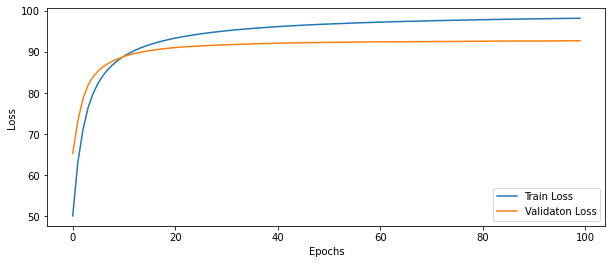

In [24]:
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(train_accuracy, label = 'Train Loss')
plt.plot(valid_accuracy, label = 'Validaton Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()